## NeuroFlow example
This notebook will introduce you to the capabilties and usage of NeuroFlow.

# Imports

Please run the cell below and fix any dependency issues before proceeding.

In [19]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import AnalyZor_Class as Analyzor
import AnalyZor_Helper

from NeuroFlow import Flow
from tqdm.notebook import tqdm
from AnalyZor_Helper import generate_mask

# Data loading

First we need to load and prepare the data for further processing. We will look at a dataset with spontaneous activity and one where the network was stimulated, both using the same chip and DIV.

In [20]:
folder = 'Example_Data'
spontaneous_data_filename = 'DIV20_Spontaneous.raw.h5'
output_folder = os.path.join(os.getcwd(), 'Output_plots')

To keep things simple, we will load the spikes extracted by the MaxLab Live Software. Alternatively, for recordings with raw data, one could use our provided spike detection.

In [21]:
spontaneous_data = Analyzor.AnalyZor(spontaneous_data_filename, inputPath = folder)
spontaneous_data.loadDataSpikesOnly()
spontaneous_flow_data = Flow(spontaneous_data)

Flow object created using AnalyZor data from DIV20_Spontaneous.raw.h5.


# Flow analysis for spontaneous data

First, we will look at at the spontaneous data. We need to select a suitable electrode to trigger our flow windows on and also define how large our individual windows should be and if a prewindow is needed.

Trigger electrode: The electrode should be part of the pathways of interest. Usually looking at the most active electrodes first is a good starting point. However, in this case we will be looking at the electrode which was later stimulated to generate the stimulate dataset.

Window size: The window should be large enough to capture the full propagation of a signal while not being so large as to capture overlapping signals all the time. A value of 300 frames (15 ms) usually works quite well. 

Pre window: If the trigger electrode is somewhere in the middle of the pathway rather than at the start, we need to define a pre-window to capture the part of the signal occuring before the trigger time. A suitable value is usually found by visual inspection of the output. (E.g. set a large window at first and put half of the window size as a pre window and then refine from there)

There also some more parameters to define for the neuroflow algorithm:

Spatial Window: Radius in pixels within which spikes are considered to be related to each other

Temporal coincidence window: Temporal window within which spikes are condsidered to be related to each other

Vector Weighting: Determines the weighting of all signal propagation vectors when combining them into an overall vector.
temporal -> vectors are linearly weighted by how soon after the original spike they occur (between 0 and 1, 1 if right after, 0 if at the very end of the coincidence window)
None -> equal weights for all vectors

In [23]:
#### Input ####

# Electrode to trigger on
trigger_electrode = 4111

# Window parameters
window_size = 10 # ms
pre_window = 0 # ms

# Neuroflow Parameters
spatial_window = 3 # pixels
temporal_coinc_window = 0.5 # ms
vector_weighting = None # other option is temporal

We can now extract the spike times for the chosen trigger electrode.

In [24]:
spike_times = spontaneous_data.spikes[np.argwhere(spontaneous_data.electrodeChannelMapping[0,:] == trigger_electrode)[0][0]][0]
boundX, boundY = spontaneous_data.get_boundaries()
trigger_x,trigger_y = AnalyZor_Helper.convert_elno_to_xy(trigger_electrode)

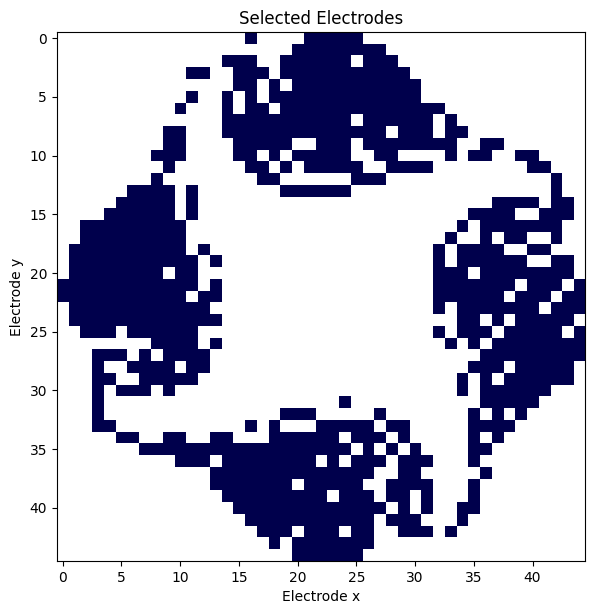

In [25]:
# We subsample the electrodes as we want, they will be only used as a background for visualisation
sampled_electrodes, sampled_coords = spontaneous_data.electrode_subsampling(min_dist=0, point_limit=1024, figureSize=(9,7), showPlotBool=True)

Flow for individual time windows triggered on the trigger electrode.

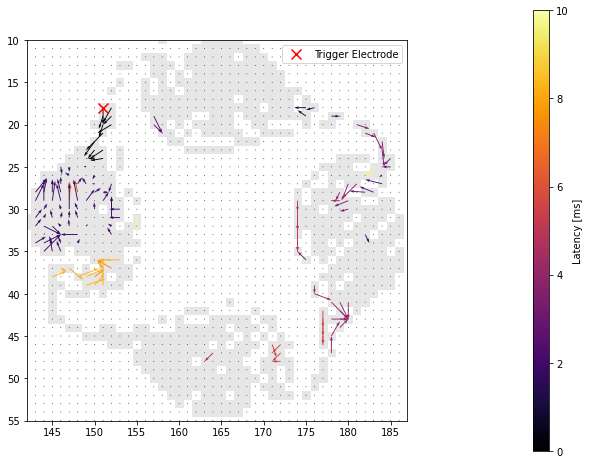

In [26]:
x,y,u,v,c = spontaneous_flow_data.fast_single_window_flow(start_frame=spike_times[7] - pre_window,
                                                   spatial_window=spatial_window,
                                                   vector_weighting=vector_weighting,
                                                   temporal_window=window_size,
                                                   verbose=False,
                                                   coincidence_window=temporal_coinc_window,
                                                   normalize=False)
fig = plt.figure(figsize=(9,7))
plt.imshow(generate_mask(sampled_electrodes), alpha = 0.1, cmap = "bone")
im = plt.quiver(x,y,v,u,c,cmap="inferno",angles='xy', scale_units='xy', scale=1, clim=[0,window_size])
plt.xlim([boundX[0], boundX[1]])
plt.ylim([boundY[0], boundY[1]])
plt.gca().invert_yaxis()
plt.scatter(trigger_y,trigger_x,c='r', marker="x", s=100, label="Trigger Electrode")
plt.legend()

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.065, 0.025, 0.874])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label="Latency [ms]", size=10, weight="regular")

## Flow over many windows 

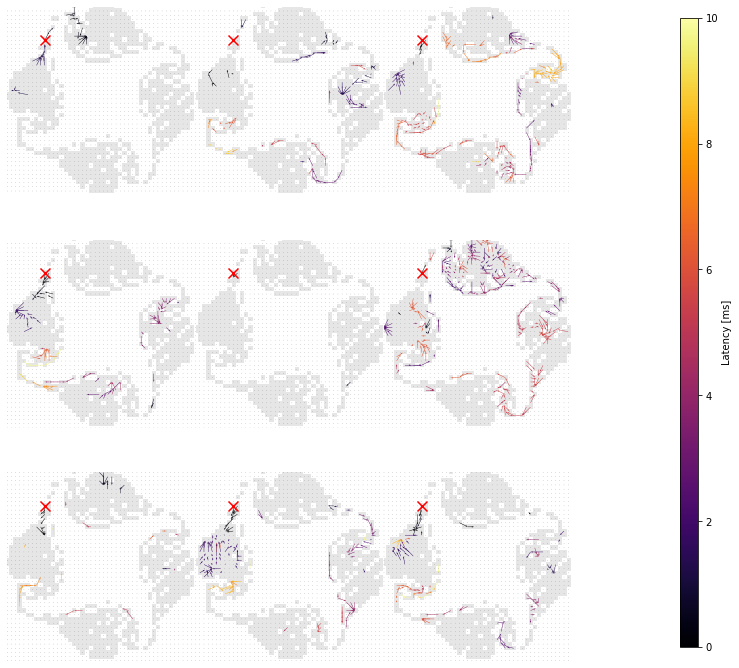

In [27]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
for i in range(9):
    start_frame = spike_times[i]-pre_window
    # Generate the matrices for the vector plot
    x,y,u,v,c = spontaneous_flow_data.fast_single_window_flow(start_frame=start_frame,
                                                       spatial_window=spatial_window,
                                                       vector_weighting=vector_weighting,
                                                       temporal_window=window_size,
                                                       verbose=False,
                                                       coincidence_window=temporal_coinc_window,
                                                       normalize=False)
    
    curr_ax = axes[int(i/3), i%3]
    curr_ax.axis('off')
    curr_ax.imshow(generate_mask(sampled_electrodes), alpha = 0.1, cmap = "bone")
    curr_ax.quiver(x,y,v,u,c,cmap='inferno', angles='xy', scale_units='xy', scale=1, clim=[0, window_size])
    curr_ax.set_xlim([boundX[0], boundX[1]])
    curr_ax.set_ylim([boundY[0], boundY[1]])
    curr_ax.scatter(trigger_y,trigger_x,c='r', marker="x", s=100, label="Trigger Electrode")
    curr_ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.065, 0.025, 0.874])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label="Latency [ms]", size=10, weight="regular")

# Flow analysis for stimulated data

Now we will run through the same procedure using stimualted data. There are some small difference which have to be considered.

1.) While initalising the analyzor object, we need to also input the stimulation electrode of interest and stimulation voltage.

2.) When loading the spike data, blankingBool has to be set to True, blanking the stimulation artefact in the data

3.) Since the signal around the stimulation is blanked, we will use the end times of these blanking windows as our trigger times. They can be accessed via stimulated_data.blankingEnd

Other than that, most of the procedure stays the same.

In [28]:
stimulated_data_filename = 'DIV_20_10782_09827_800.raw.h5'
stim_electrode = 9827
stimulated_data = Analyzor.AnalyZor(stimulated_data_filename, inputPath = folder, stimulation_electrodes = [stim_electrode], stimulation_voltages=[500])
stimulated_data.loadDataSpikesOnly(blankingBool=True)
stimulated_flow_data = Flow(stimulated_data)

Flow object created using AnalyZor data from DIV_20_10782_09827_800.raw.h5.


In [29]:
spike_times = stimulated_data.blankingEnd
boundX, boundY = stimulated_data.get_boundaries()
stim_x,stim_y = AnalyZor_Helper.convert_elno_to_xy(stim_electrode)

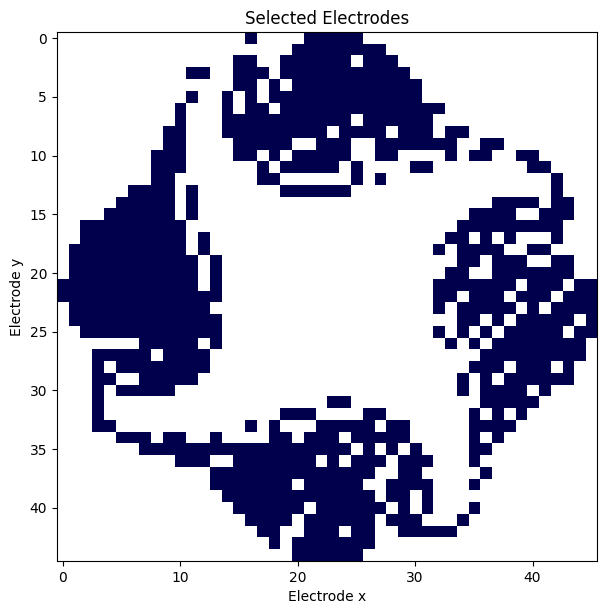

In [30]:
# We subsample the electrodes as we want, they will be only used as a background for visualisation
sampled_electrodes, sampled_coords = stimulated_data.electrode_subsampling(min_dist=0, point_limit=1024, figureSize=(9,7), showPlotBool=True)

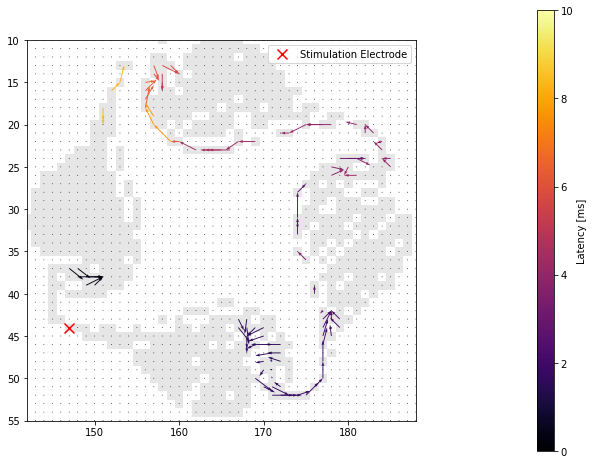

In [31]:
x,y,u,v,c = stimulated_flow_data.fast_single_window_flow(start_frame=spike_times[5] - pre_window,
                                                   spatial_window=spatial_window,
                                                   vector_weighting=None,
                                                   temporal_window=window_size,
                                                   verbose=False,
                                                   coincidence_window=temporal_coinc_window,
                                                   normalize=False)
fig = plt.figure(figsize=(9,7))
plt.imshow(generate_mask(sampled_electrodes), alpha = 0.1, cmap = "bone")
im = plt.quiver(x,y,v,u,c,cmap="inferno",angles='xy', scale_units='xy', scale=1, clim=[0,window_size])
plt.xlim([boundX[0], boundX[1]])
plt.ylim([boundY[0], boundY[1]])
plt.gca().invert_yaxis()
plt.scatter(stim_y,stim_x,c='r', marker="x", s=100, label="Stimulation Electrode")
plt.legend()

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.065, 0.025, 0.874])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label="Latency [ms]", size=10, weight="regular")

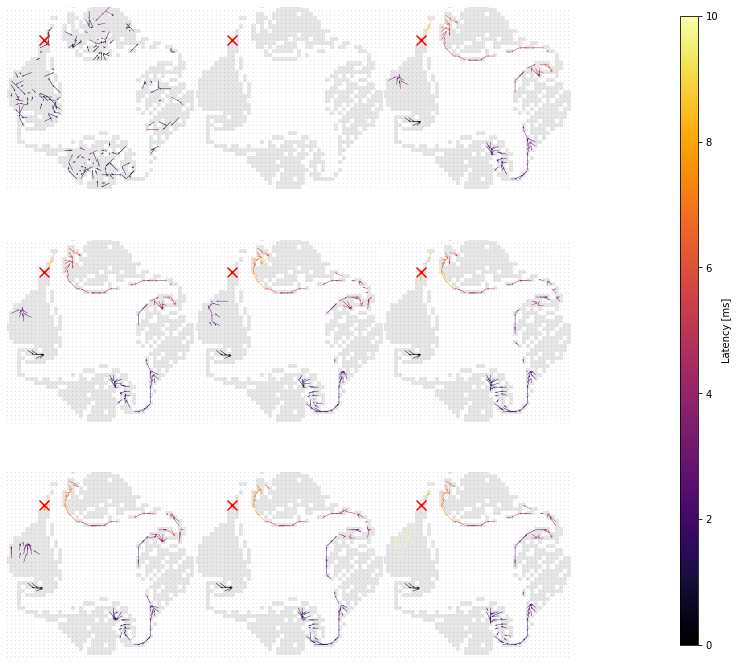

In [32]:
fig, axes = plt.subplots(3,3,figsize=(10,10))
for i in range(9):
    start_frame = spike_times[i]-pre_window
    # Generate the matrices for the vector plot
    x,y,u,v,c = stimulated_flow_data.fast_single_window_flow(start_frame=start_frame,
                                                       spatial_window=spatial_window,
                                                       vector_weighting=vector_weighting,
                                                       temporal_window=window_size,
                                                       verbose=False,
                                                       coincidence_window=temporal_coinc_window,
                                                       normalize=False)
    
    curr_ax = axes[int(i/3), i%3]
    curr_ax.axis('off')
    curr_ax.imshow(generate_mask(sampled_electrodes), alpha = 0.1, cmap = "bone")
    curr_ax.quiver(x,y,v,u,c,cmap='inferno', angles='xy', scale_units='xy', scale=1, clim=[0, window_size])
    curr_ax.set_xlim([boundX[0], boundX[1]])
    curr_ax.set_ylim([boundY[0], boundY[1]])
    curr_ax.scatter(trigger_y,trigger_x,c='r', marker="x", s=100, label="Stimulation Electrode")
    curr_ax.invert_yaxis()
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.065, 0.025, 0.874])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label="Latency [ms]", size=10, weight="regular")

# Metric extraction over all stimulation windows

Now that we know how to extract flow maps for single windows, we can do the same thing for all e.g. all stimulation cycles in a data file. With all these indivual flow maps we can then proceed todo PCA and clustering to try and extract different pathways in a mostly automated manner.

First we collect all the flow maps and some extracted metrics over the entire dataset.

In [33]:
metrics, us, vs, cs = stimulated_flow_data.stimulated_pathway_metric_extraction(spike_limit=None, pre_window=pre_window,
                                       total_window_size=window_size, spatial_window=spatial_window, coincidence_window=temporal_coinc_window, weighting=vector_weighting,
                                       length_threshold=1, normalize=False, verbose=False)

The same can also be done for spontaneous data using the function "spontaneous_pathway_metric_extraction" which additionally needs a trigger_electrode as an input.

## Using PCA on the flattended u-v arrays and then clustering using DBSCAN

To keep things simple, one can simply apply PCA to all of the collected flow maps and then cluster the low-dimensionality data using some robust clustering method such as DBSCAN. Parameter tuning is not trivial but can be done by inspecting the results in both the 3d illustration below as well as the corresponding flow maps. 

Clusters to chose from: [0 1 2]


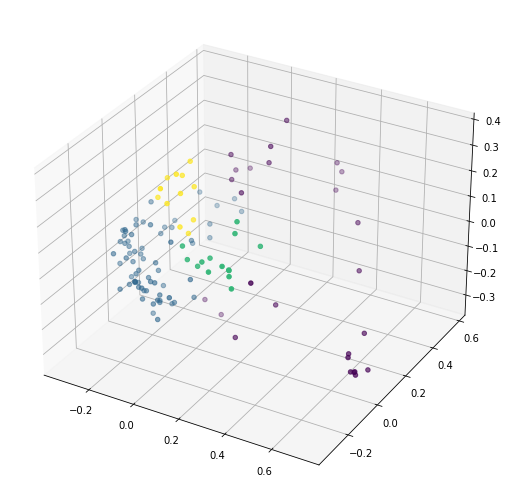

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from mpl_toolkits.mplot3d import Axes3D

uv_vecs = np.array([np.vstack((u.flatten(), v.flatten())).T.flatten() for u,v in zip(us, vs)])

uv_vecs = normalize(uv_vecs, axis=1)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(uv_vecs)

dbscan = DBSCAN(eps=0.16, min_samples=10)
clusters = dbscan.fit_predict(pca_data)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data[:,0], pca_data[:,1], pca_data[:,2], c=clusters)

print("Clusters to chose from: " + str(np.unique(dbscan.labels_)[1:]));

## Visualising clustering results

In [35]:
cluster_to_show = 0

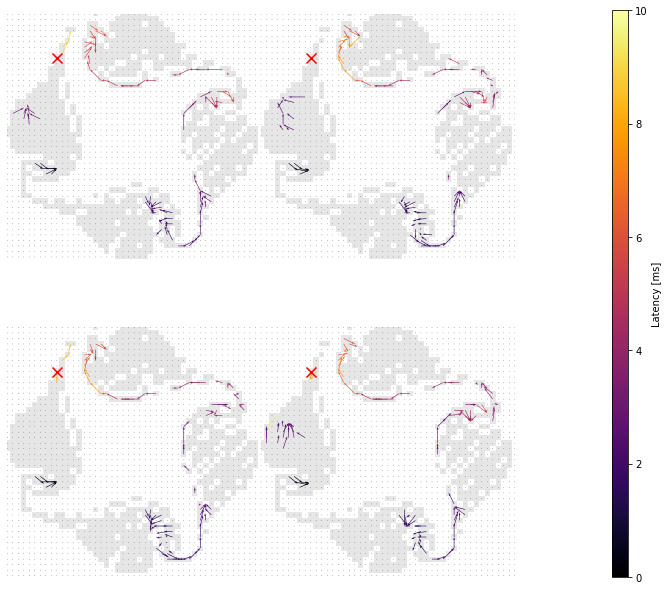

In [36]:
# Cluster -1 is always outliers, select 0,... for extracted clusters
cluster_ind = np.argwhere(dbscan.labels_ == cluster_to_show)
fig, axes = plt.subplots(2,2,figsize=(9,9))
for i in range(4):
    ind = cluster_ind[i][0]
    u = us[ind]
    v = vs[ind]
    c = cs[ind]
    curr_ax = axes[int(i/2), i%2]
    curr_ax.axis('off')
    curr_ax.imshow(generate_mask(sampled_electrodes), alpha = 0.1, cmap = "bone")
    curr_ax.quiver(x,y,v,u,c,cmap='inferno', angles='xy', scale_units='xy', scale=1, clim=[0, window_size])
    curr_ax.set_xlim([boundX[0], boundX[1]])
    curr_ax.set_ylim([boundY[0], boundY[1]])
    curr_ax.invert_yaxis()
    curr_ax.scatter(trigger_y,trigger_x,c='r', marker="x", s=100, label="Stimulated Electrode")
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.95, 0.065, 0.025, 0.874])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label="Latency [ms]", size=10, weight="regular")